<a href="https://colab.research.google.com/github/justlab11/MLTSA22_JLabombard/blob/main/HW7/HW7_JLabombard_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This is an exercise on feature extractoin and Gaussian Processes interpolation of sparse time series.

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in light emission in 6 different bands (i.e. wavelength ranges). The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good friend Gautham Narayan) to get started and ingest and preprocess the PLASTiCC challenge data. If you are not familiar with classes (object oriented syntax) do not worry about it: I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and fit the time series with Gaussian Processes. 



In [ ]:
!pip install george

In [ ]:
import pandas as pd
import numpy as np
import pylab as pl
from sklearn import preprocessing
import george
from george import kernels

%pylab inline


Populating the interactive namespace from numpy and matplotlib


# TASK I :  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018
 or from zenodo
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ
 Choose how to do it but make sure that it is a reproducible way. You will need the **training data and the metadata files** only - you wont need to use the test data


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) # this is because my drive is refusing to update

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/.kaggle

/content/drive/MyDrive/.kaggle


In [ ]:
import json
import os

envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [ ]:
cd /content/drive/MyDrive/MLTSA22/

/content/drive/MyDrive/MLTSA22


In [ ]:
!mkdir HW7

In [ ]:
cd HW7

/content/drive/MyDrive/MLTSA22/HW7


In [ ]:
!kaggle competitions download -c PLAsTiCC-2018

100% 13.8G/13.8G [03:03<00:00, 19.8MB/s]
100% 13.8G/13.8G [03:03<00:00, 80.5MB/s]


In [ ]:
!unzip PLAsTiCC-2018

Archive:  PLAsTiCC-2018.zip
  inflating: data_note.pdf           
  inflating: sample_submission.csv   
  inflating: test_set.csv            
  inflating: test_set_batch1.csv     
  inflating: test_set_batch10.csv    
  inflating: test_set_batch11.csv    
  inflating: test_set_batch2.csv     
  inflating: test_set_batch3.csv     
  inflating: test_set_batch4.csv     
  inflating: test_set_batch5.csv     
  inflating: test_set_batch6.csv     
  inflating: test_set_batch7.csv     
  inflating: test_set_batch8.csv     
  inflating: test_set_batch9.csv     
  inflating: test_set_metadata.csv   
  inflating: test_set_sample.csv     
  inflating: training_set.csv        
  inflating: training_set_metadata.csv  


In [ ]:
lcvs = pd.read_csv("training_set.csv")

In [ ]:
lcvs.head() 

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [ ]:
print("The shape of light curves dataset is:", lcvs.shape)

The shape of light curves dataset is: (1421705, 6)


In [ ]:
#check missing values
lcvs.isna().sum()

object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64

Read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands 

In [ ]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [ ]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [ ]:
metadata = pd.read_csv("training_set_metadata.csv")
metadata.tail()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
7843,130739978,26.718750,-14.940303,172.342697,-72.255675,0,0.0000,0.0000,0.0000,NaN,0.013,65
7844,130755807,120.101349,-62.696659,275.742955,-16.509746,0,0.1725,2.5606,1.1146,46.6108,0.136,90
7845,130762946,203.108109,-55.682144,308.728904,6.727511,0,0.0000,0.0000,0.0000,NaN,0.430,16
7846,130772921,79.101562,-35.501846,239.172243,-33.827844,0,0.0000,0.0000,0.0000,NaN,0.034,65
7847,130779836,301.992188,-17.426323,25.102988,-24.511101,0,0.0000,0.0000,0.0000,NaN,0.091,6


In [ ]:
print("The metadata columns are: ", metadata.columns)

The metadata columns are:  Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')


In [ ]:
print("The metadata dataset contains features: ", metadata.shape[1])

The metadata dataset contains features:  12


# TASK II : data exploration and visualization - plot some time series 
Visualize my data to get a sense of what we are working with. 





Plot light curves for 10 objects. 

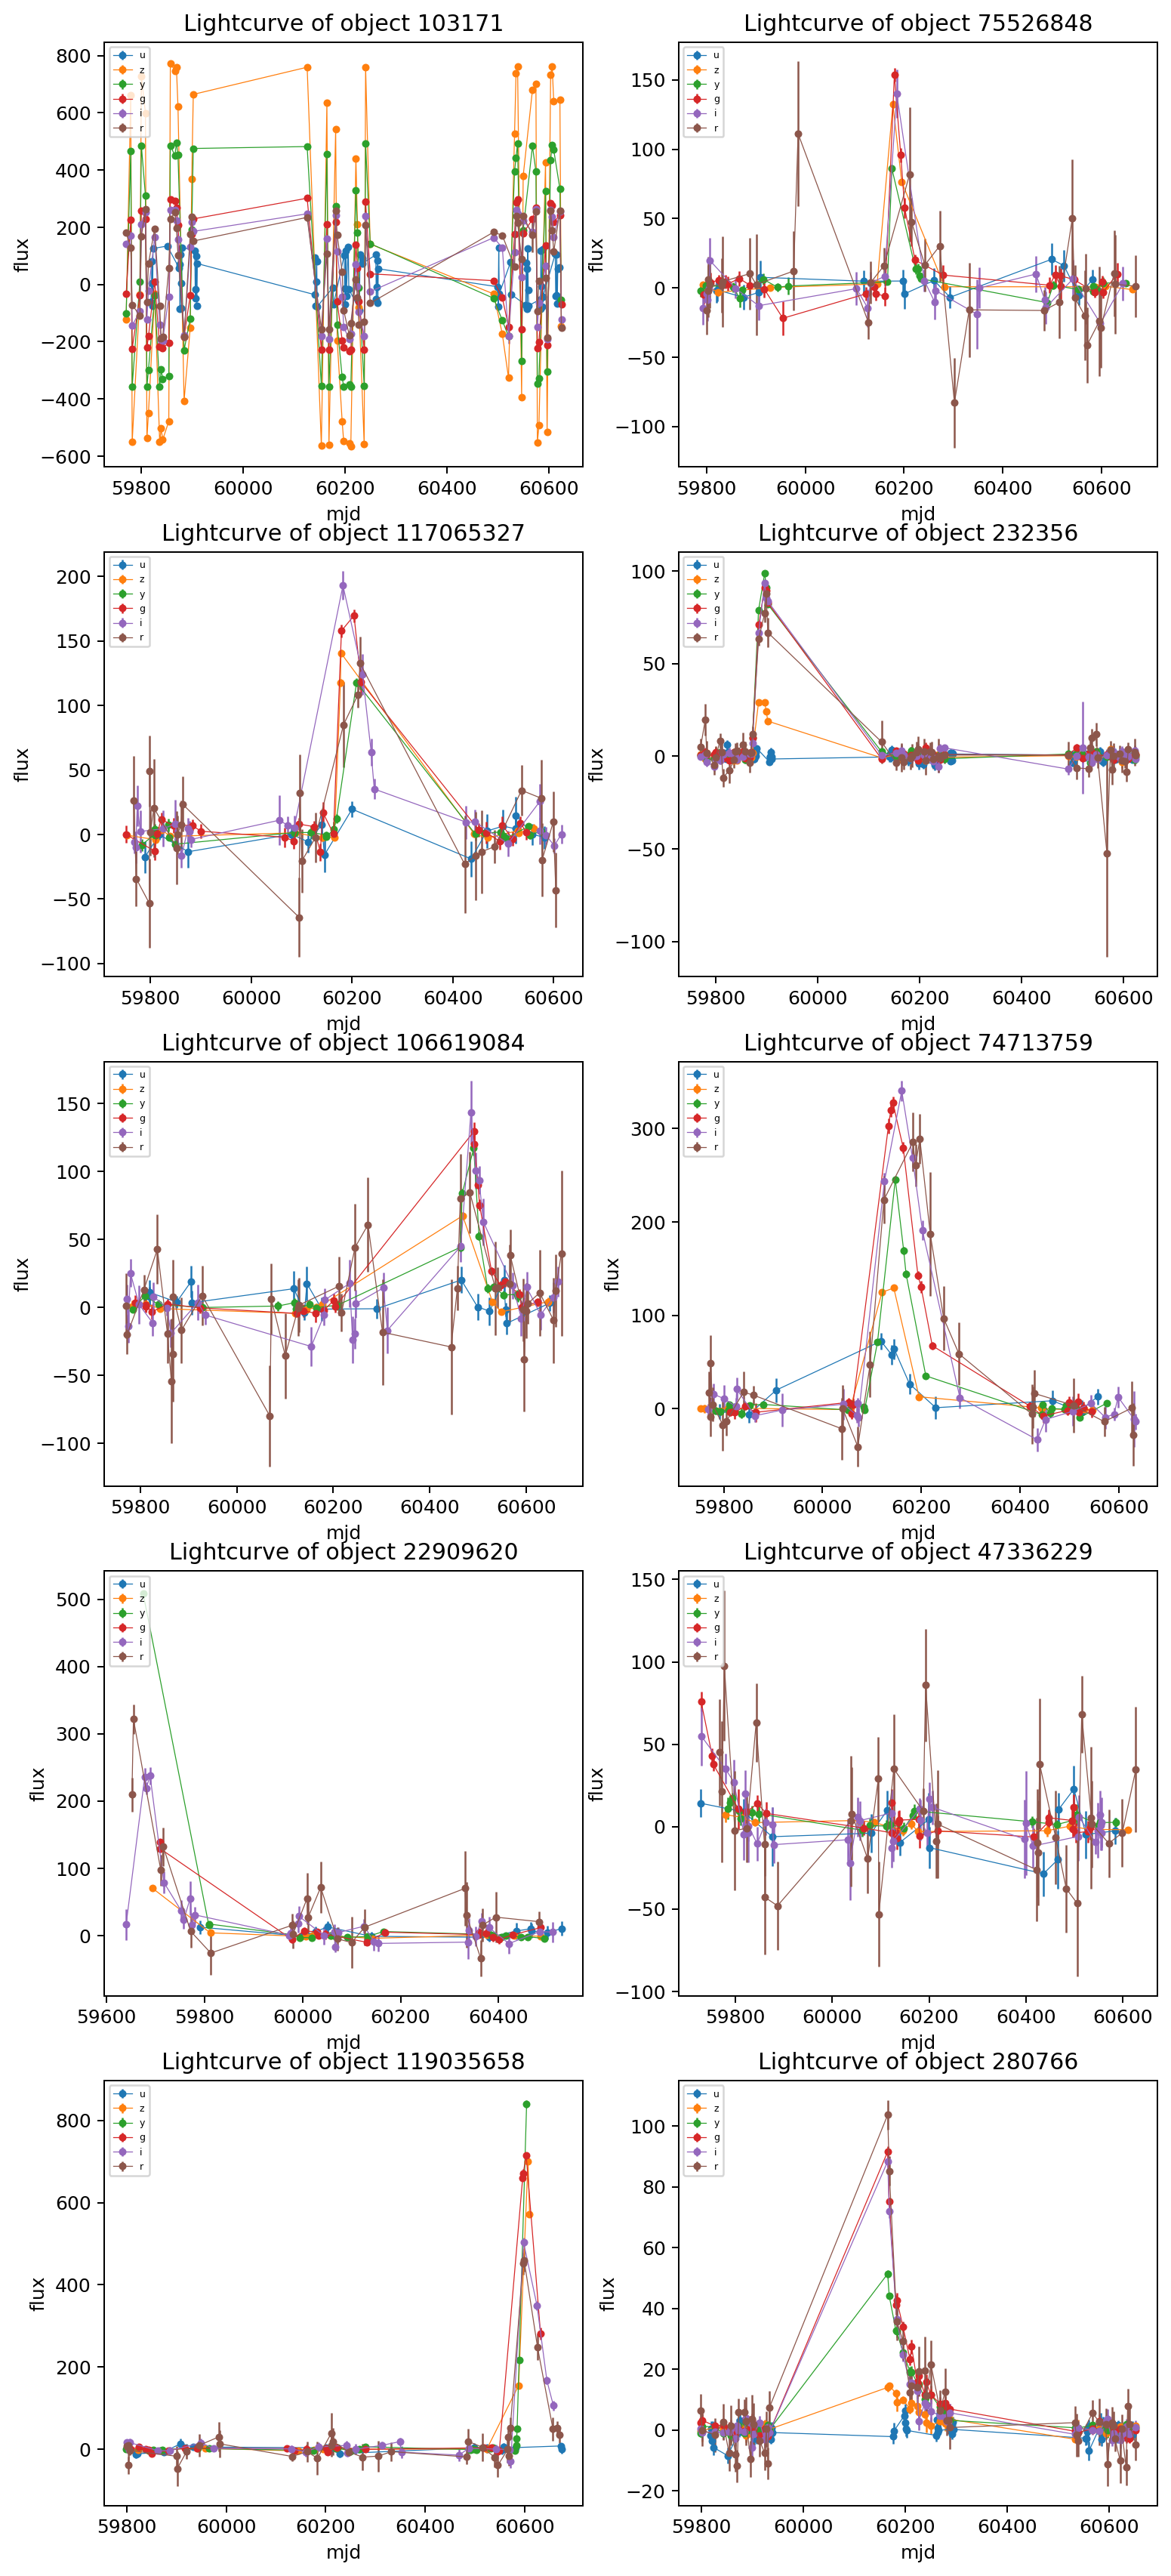

In [ ]:
# pl.plot(lcvs[lcvs["object_id"] == 615]["mjd"])
# fig, ax = pl.subplot(1,10,1)
pl.figure(figsize=(10,24), dpi=180)

obj_id = np.random.choice(lcvs["object_id"].unique(), 10)
for i in range(len(obj_id)):
  pl.subplot(5, 2, i+1)
  for j in range(6):
    a = lcvs[lcvs["object_id"] == obj_id[i]][lcvs[lcvs["object_id"] == obj_id[i]]["passband"] == j]["flux"]
    t = lcvs[lcvs["object_id"] == obj_id[i]][lcvs[lcvs["object_id"] == obj_id[i]]["passband"] == j]["mjd"]
    b = lcvs[lcvs["object_id"] == obj_id[i]][lcvs[lcvs["object_id"] == obj_id[i]]["passband"] == j]["flux_err"]
    pl.errorbar(t,a,yerr=b, elinewidth=1, linewidth=.5, fmt=".-")
    pl.title(f"Lightcurve of object {obj_id[i]}")
    pl.ylabel("flux")
    pl.xlabel("mjd")
  pl.legend(["u","z","y","g","i","r"], loc=2, prop={'size': 5})
  # pl.plot(lcvs[lcvs["object_id"] == obj_id[i]]["mjd"].values, lcvs[lcvs["object_id"] == obj_id[i]]["flux"].values)

pl.show()

Figure 1: Plots of 10 different lightcurves. Each lightcurve contains 6 lines, one for each passband. Points that deviate from the norm have large errorbars compared to those that follow a noticable path. The lightcurves are unique and have different shapes.

<font color="red">FBB good</font>

Plot explicitly object 84716

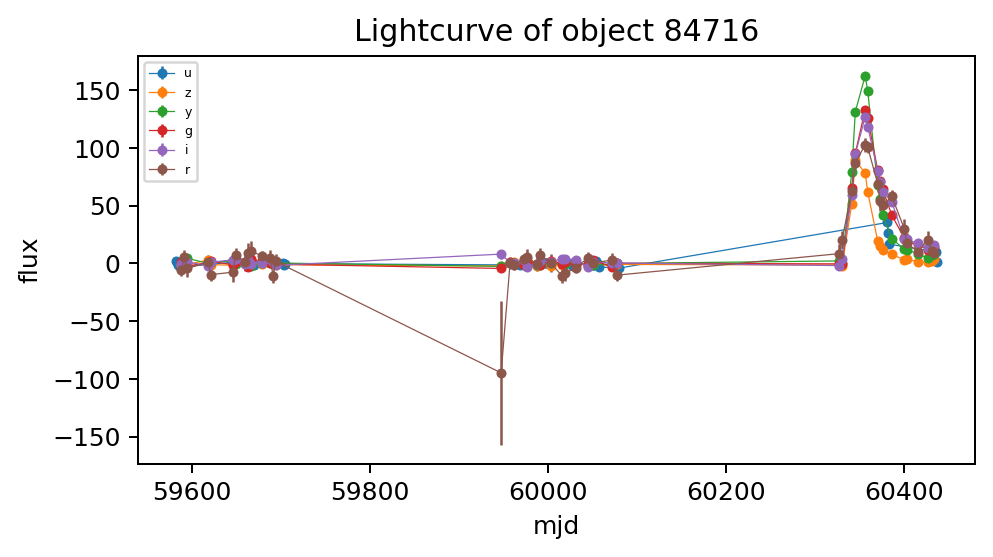

In [ ]:
pl.figure(figsize=(6,3), dpi=180)
# pl.plot(lcvs[lcvs["object_id"] == 84716]["mjd"].values, lcvs[lcvs["object_id"] == 84716]["flux"].values)

for j in range(6):
    a = lcvs[lcvs["object_id"] == 84716][lcvs[lcvs["object_id"] == 84716]["passband"] == j]["flux"]
    t = lcvs[lcvs["object_id"] == 84716][lcvs[lcvs["object_id"] == 84716]["passband"] == j]["mjd"]
    b = lcvs[lcvs["object_id"] == 84716][lcvs[lcvs["object_id"] == 84716]["passband"] == j]["flux_err"]
    pl.errorbar(t,a,yerr=b, elinewidth=1, linewidth=.5, fmt=".-")
    pl.title(f"Lightcurve of object {84716}")
    pl.ylabel("flux")
    pl.xlabel("mjd")
pl.legend(["u","z","y","g","i","r"], loc=2, prop={'size': 5})

Figure 2: Plot of the lightcurve for object 84716. There was not much light for most of the recorded time until the end. There is a large brown errorbar at the bottom (mjd ~= 59950) where a brown point is located. This brown point is far off of the other brown points and is likely an error.

<font color="red">FBB good</font>

# TASK III: Extract features

Feature extraction refers to the extraction of statistical features of the datapoints or the generation of low dimensional representations of the data points that can then be passed to a classifier/regression

Extract at least 4 features including at least 1 feature from all three category below

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

Examples of features you can extract:

- **from the original lightcurve**: 
    - mean, 
    - standard deviation, 
    - skewness, 
    - kurthosis, 
    - minimum 
    - maximmum,
    - error on the minimum and 
    - error on the maximum, 
- **from the standardized lightcurve**:
    - median 
    - slope of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl; this is one of the positions in the sky variables: important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)


Extract at least 4 features including 1 features from all three category above: original lcv, standardized lcv, metadata. Justify each feature. Coming up with different features than the ones I suggested is very welcome! Remember that if the features are extracted from the time series there will be 4 features for each passbands.

Note: we are working with bigg-ish data! 
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready. 
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar. 


describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

        

### extract some features from the raw lightcurve - 


higher order moments of the distribution can be obtained with the scipy.stats.moment() function which can be applied to a grouby() object
note that this way you can apply a function that takes only one argument, the argument over which groupby iterates (the flux here). But moments take 2: the value and the moment Create a function call

In [ ]:
#example (you can use this code but this wont count for your 4 features)
# means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()
# means
lcvs.groupby(["object_id", "passband"])

Features from original lightcurve:
  - mean - the mean gives the average of the data which is generally good to know
  - standard deviation - the values are not guaranteed to be close to the mean. The standard deviation is good for seeing how spread out the values are in the data.
  - minimums - provides the lowest possible values for each segment
  - maximums - provides the largest possible values for each segment

Feature from standardized lightcurve:
  - median - the mean can fall apart when there are outliers. The median provides a good backup in case the mean does not work.

Features from the metadata:
  - decl - the object's position in the sky. This is useful for determining whether the object is in our galaxy or outside of our galaxy.

In [ ]:
# features from raw lightcurve
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()
stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()
mins = lcvs.groupby(["object_id", "passband"])[["flux"]].min()
maxes = lcvs.groupby(["object_id", "passband"])[["flux"]].max()

means.rename(columns = {'flux':'means'}, inplace = True)
stds.rename(columns = {'flux':'stds'}, inplace = True)
mins.rename(columns = {'flux':'mins'}, inplace = True)
maxes.rename(columns = {'flux':'maxes'}, inplace = True)

Even with the same standard deviation two distribution can be very different. 
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties because outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation). 


Standardize the lcvs and extract some features from the raw lightcurve - 


You can do it use  the preprocessing.scale function and groupby, which group by object and band. It does its job, but it is slow

In [ ]:
flux_scaled_df = lcvs.groupby(["object_id", "passband"])["flux"].apply(lambda x: (x-x.mean())/x.std())
# flux_err_scaled_df = lcvs.groupby(["object_id", "passband"])["flux_err"].apply(lambda x: (x-x.mean())/x.std())
flux_err_scaled_df = lcvs.groupby(["object_id", "passband"]).apply(lambda x: (x["flux_err"]-x["flux"].mean())/x["flux"].std())

lcvs["flux_scaled"] = flux_scaled_df
lcvs["flux_err_scaled"] = flux_err_scaled_df.values

meds = lcvs.groupby(["object_id", "passband"])[["flux_scaled"]].median()
meds.rename(columns = {'flux_scaled':'medians'}, inplace = True)

Note: the median of the standardizeed distribution would convey the location of the "center of mass" of the data with respect to the mean


parametric features: extract some features that come from simple models of the lightcurve, e.g. line fits



the goodness of fit for these models is also a potential feature

Data Organization: you can put all your features in a dataframe using merge at each step merging each new feature with the olde ones


In [ ]:
#example
features = means
features_lst = [stds, mins, maxes, meds]
for i in features_lst:
  features = features.merge(i, left_index=True, right_index=True)
# features = pandas.merge(, left_index=True, right_index=True)
features.head()

means        stds         mins       maxes   medians
object_id passband                                                           
615       0          -3.254554   83.944735  -116.913223  125.182808 -0.080537
          1        -385.699911  601.787302 -1100.440063  660.626343 -0.170090
          2        -134.146566  455.121346  -681.858887  611.984558 -0.289021
          3        -121.103501  335.425053  -530.644592  445.737061 -0.122434
          4         -55.954592  291.803449  -422.184509  381.953735 -0.163078

NOTE: when you merge the metadata features you are going to have to do some gymnastic with the indices: this is because the data has 2 indices columns: the object id and the bandpass id, while the metadata has only 1 index: the object id. 

You can use the function unstuck - here is an example line of code of what worked for me **but** it kind of depends on how you organized your dataframe so this is not guaranteed to work!

In [ ]:
features["decl"] = np.nan
ids = lcvs["object_id"].unique()
for i in range(len(ids)):
  features.loc[ids[i], :]["decl"] = metadata["decl"][i]

In [ ]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(0).unstack([1,2])
for i in range(5):
  allfeatures.drop((i, "decl"), 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


passband          0                                                        1  \
              means       stds        mins       maxes   medians       means   
object_id                                                                      
615       -3.254554  83.944735 -116.913223  125.182808 -0.080537 -385.699911   
713       -2.720398   7.113509  -14.735178   14.509829 -0.052914   -1.019804   
730       -0.048080   1.828872   -3.459960    5.942166  0.039463    0.141057   
745        1.797523   4.374445   -3.874349   18.014029 -0.169349    5.717394   
1124       0.660948   2.360084   -6.804703    5.330927 -0.033864    4.634637   

passband                                                  ...           4  \
                 stds         mins       maxes   medians  ...        stds   
object_id                                                 ...               
615        601.787302 -1100.440063  660.626343 -0.170090  ...  291.803449   
713          5.712334   -11.715749    9.129021  0.080189  ...    6.406989   
730          1.807229    -3.393080    5.693109  0.016754  ...   10.710344   
745         25.964659    -3.618410  192.244293 -0.185994  ...   33.069053   
1124         8.107525    -2.622109   37.170177 -0.429236  ...   26.865913   

passband                                             5              \
                 mins       maxes   medians      means        stds   
object_id                                                            
615       -422.184509  381.953735 -0.163078 -47.449847  294.779522   
713        -12.286801    9.827934  0.016870  -1.794175    7.094073   
730         -5.836310   41.159981 -0.308522   4.539396   13.332758   
745        -15.494463  183.633118 -0.358773  10.746138   26.060130   
1124       -16.543753  143.600189 -0.303771   6.896742   21.434627   

passband                                                
                 mins       maxes   medians       decl  
object_id                                               
615       -422.815094  378.188141 -0.129163 -61.943836  
713        -14.211164   14.770886 -0.094281 -27.784405  
730        -19.159811   47.310059 -0.149763  -6.579593  
745        -10.249387  141.513290 -0.306851 -45.586655  
1124       -10.860540  109.157585 -0.229697 -63.823658  

[5 rows x 31 columns]

In [ ]:
#EXAMPLE OF A POTENTIAL DATAFRAME OUTPUT
allfeatures.head()

passband          0                                                        1  \
              means       stds        mins       maxes   medians       means   
object_id                                                                      
615       -3.254554  83.944735 -116.913223  125.182808 -0.080537 -385.699911   
713       -2.720398   7.113509  -14.735178   14.509829 -0.052914   -1.019804   
730       -0.048080   1.828872   -3.459960    5.942166  0.039463    0.141057   
745        1.797523   4.374445   -3.874349   18.014029 -0.169349    5.717394   
1124       0.660948   2.360084   -6.804703    5.330927 -0.033864    4.634637   

passband                                                  ...           4  \
                 stds         mins       maxes   medians  ...        stds   
object_id                                                 ...               
615        601.787302 -1100.440063  660.626343 -0.170090  ...  291.803449   
713          5.712334   -11.715749    9.129021  0.080189  ...    6.406989   
730          1.807229    -3.393080    5.693109  0.016754  ...   10.710344   
745         25.964659    -3.618410  192.244293 -0.185994  ...   33.069053   
1124         8.107525    -2.622109   37.170177 -0.429236  ...   26.865913   

passband                                             5              \
                 mins       maxes   medians      means        stds   
object_id                                                            
615       -422.184509  381.953735 -0.163078 -47.449847  294.779522   
713        -12.286801    9.827934  0.016870  -1.794175    7.094073   
730         -5.836310   41.159981 -0.308522   4.539396   13.332758   
745        -15.494463  183.633118 -0.358773  10.746138   26.060130   
1124       -16.543753  143.600189 -0.303771   6.896742   21.434627   

passband                                                
                 mins       maxes   medians       decl  
object_id                                               
615       -422.815094  378.188141 -0.129163 -61.943836  
713        -14.211164   14.770886 -0.094281 -27.784405  
730        -19.159811   47.310059 -0.149763  -6.579593  
745        -10.249387  141.513290 -0.306851 -45.586655  
1124       -10.860540  109.157585 -0.229697 -63.823658  

[5 rows x 31 columns]

what is the shape of your final feature space?

In [ ]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1]))

My feature space is 31 features (columns)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


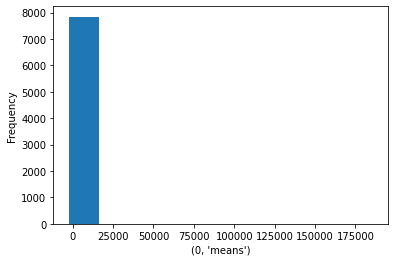

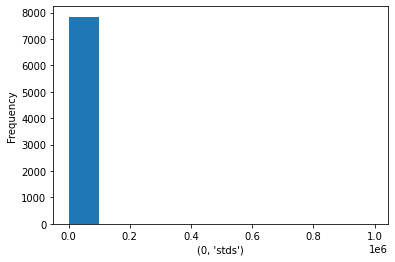

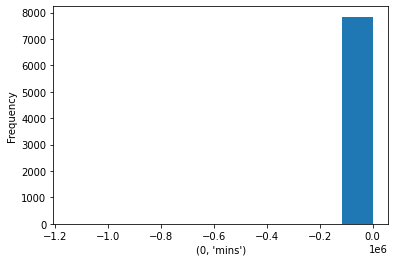

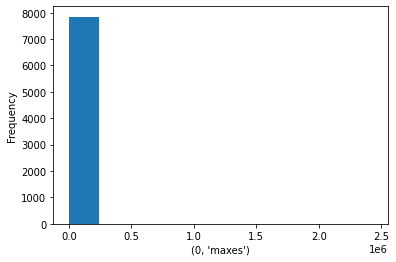

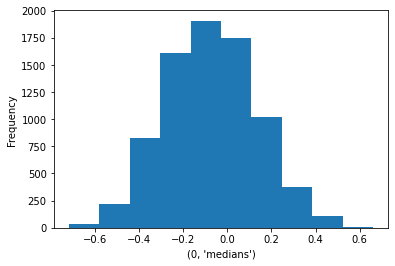

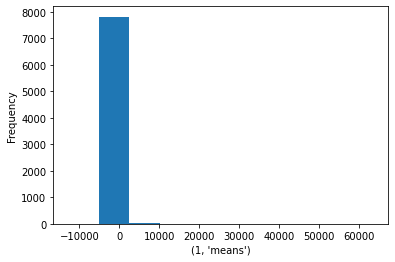

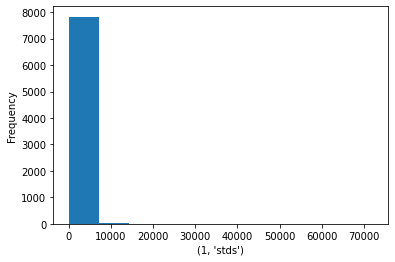

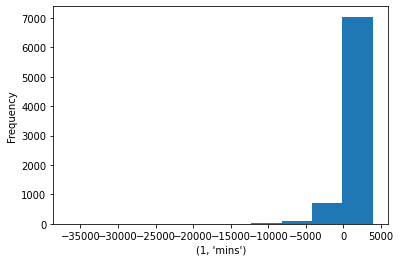

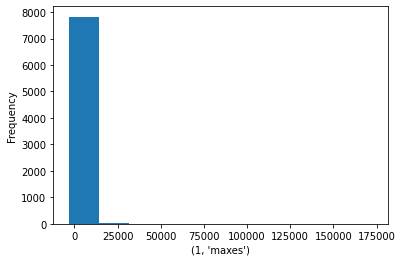

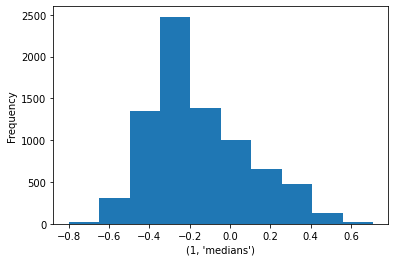

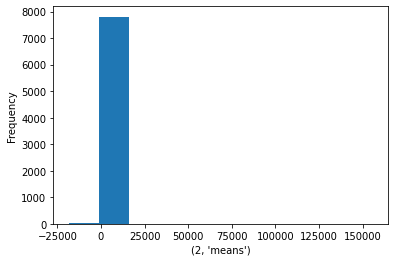

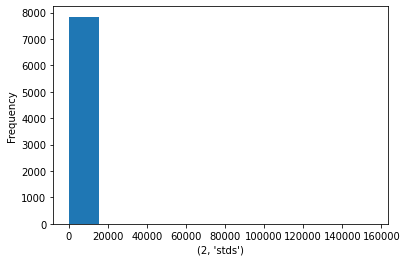

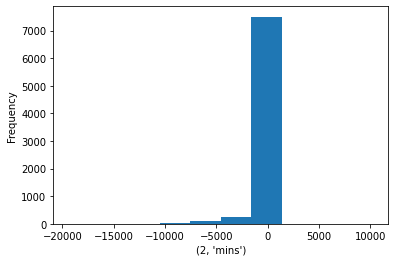

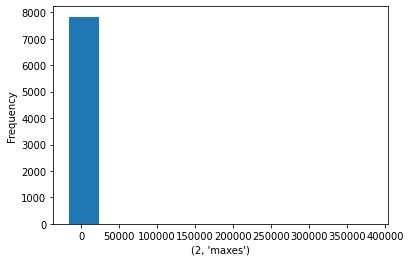

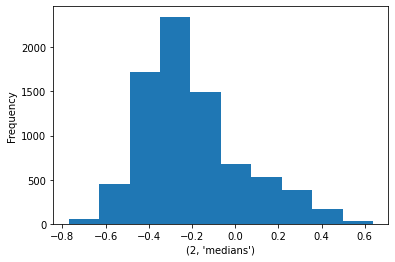

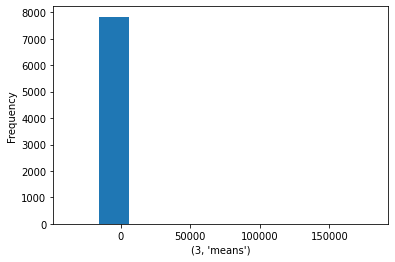

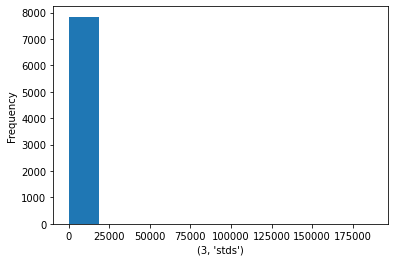

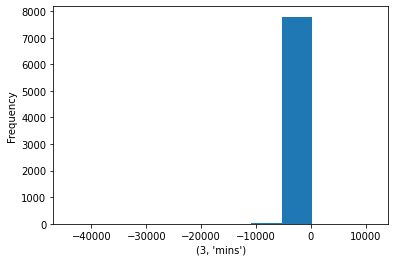

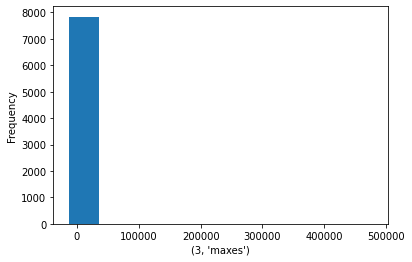

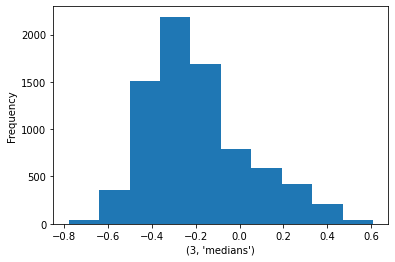

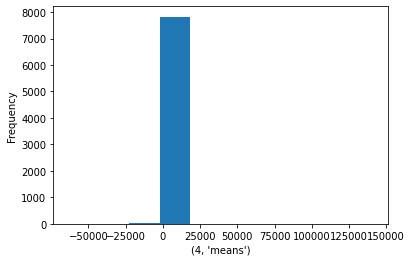

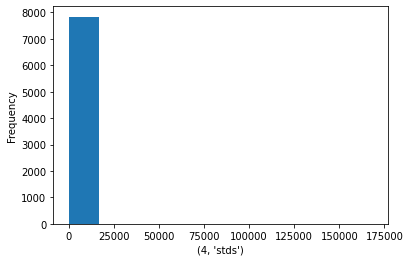

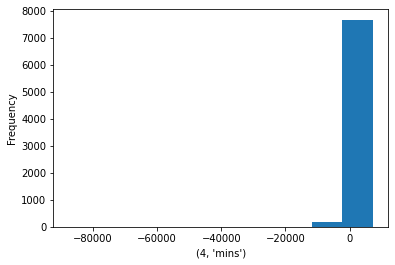

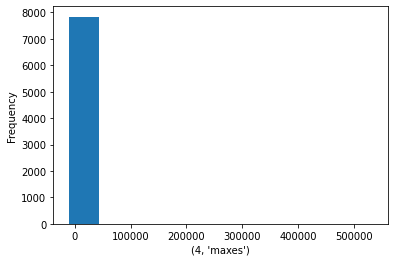

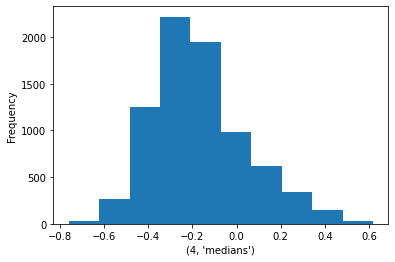

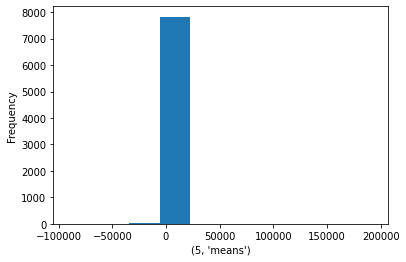

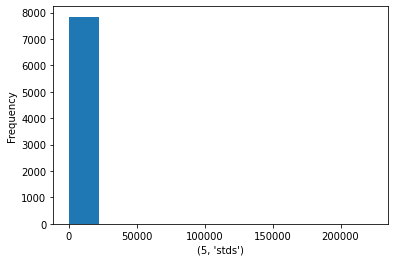

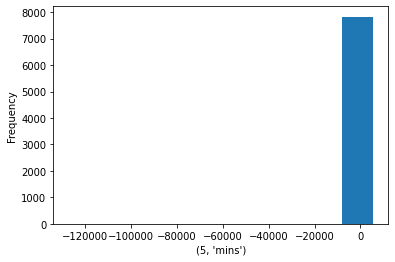

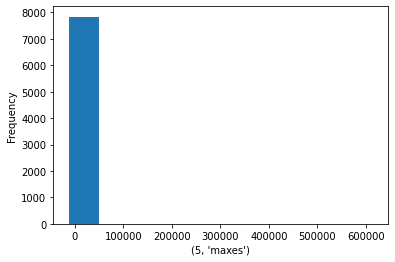

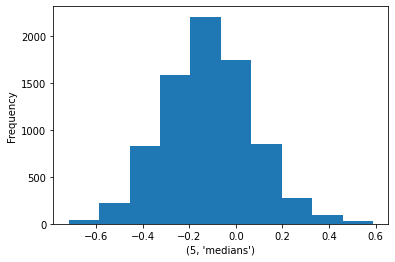

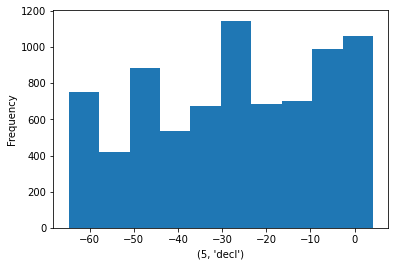

In [ ]:
for i in allfeatures.columns:
  pl.figure()
  pl.hist(allfeatures[i])
  pl.xlabel(i)
  pl.ylabel('Frequency')

Figure 3: Histograms of different features on 6 different bands. The features are means, standard deviations, minimums, maximums, medians, and the only feature that does not belong to a band: decl. Most of the histograms show almost no variation due to outliers skewing the histogram's x-axis . The non-standardized data does not work well on the histogram. The median data looks correct, with most following a right-scew distribution or normal distribution.

<font color="red">FBB good</font>

# TASK IV : Gaussian Processes

Take the time series and fit them with GPs. 
- use the george package goerge (see class demo https://github.com/fedhere/MLTSA22_FBianco/blob/main/Lab5GP/GP_examples.ipynb)
- make sure you use the standardized time series
- make sure you process the uncertainty as well as the data in the standardization!
- choose an appropriate kernel (e.g. the composite one we use in class that enables periodicity as well as stockastic variations)
- take a subset of the time series, ~10, making sure that they are of different types
- fit the GP kernel to each time series band by band
- collect the best fit parameters and describe their variance - can all the time series be fit reasonably with the same kernel? how would you initialize the fit for the whole ensamble?



Initial ln-likelihood: -25.55
Initial parameters: -0.08
Initial ln-likelihood: -17.32
Initial parameters: -0.09
Initial ln-likelihood: -41.24
Initial parameters: -0.06
Initial ln-likelihood: -33.68
Initial parameters: -0.05
Initial ln-likelihood: -61.40
Initial parameters: -0.04
Initial ln-likelihood: -149.28
Initial parameters: -0.02


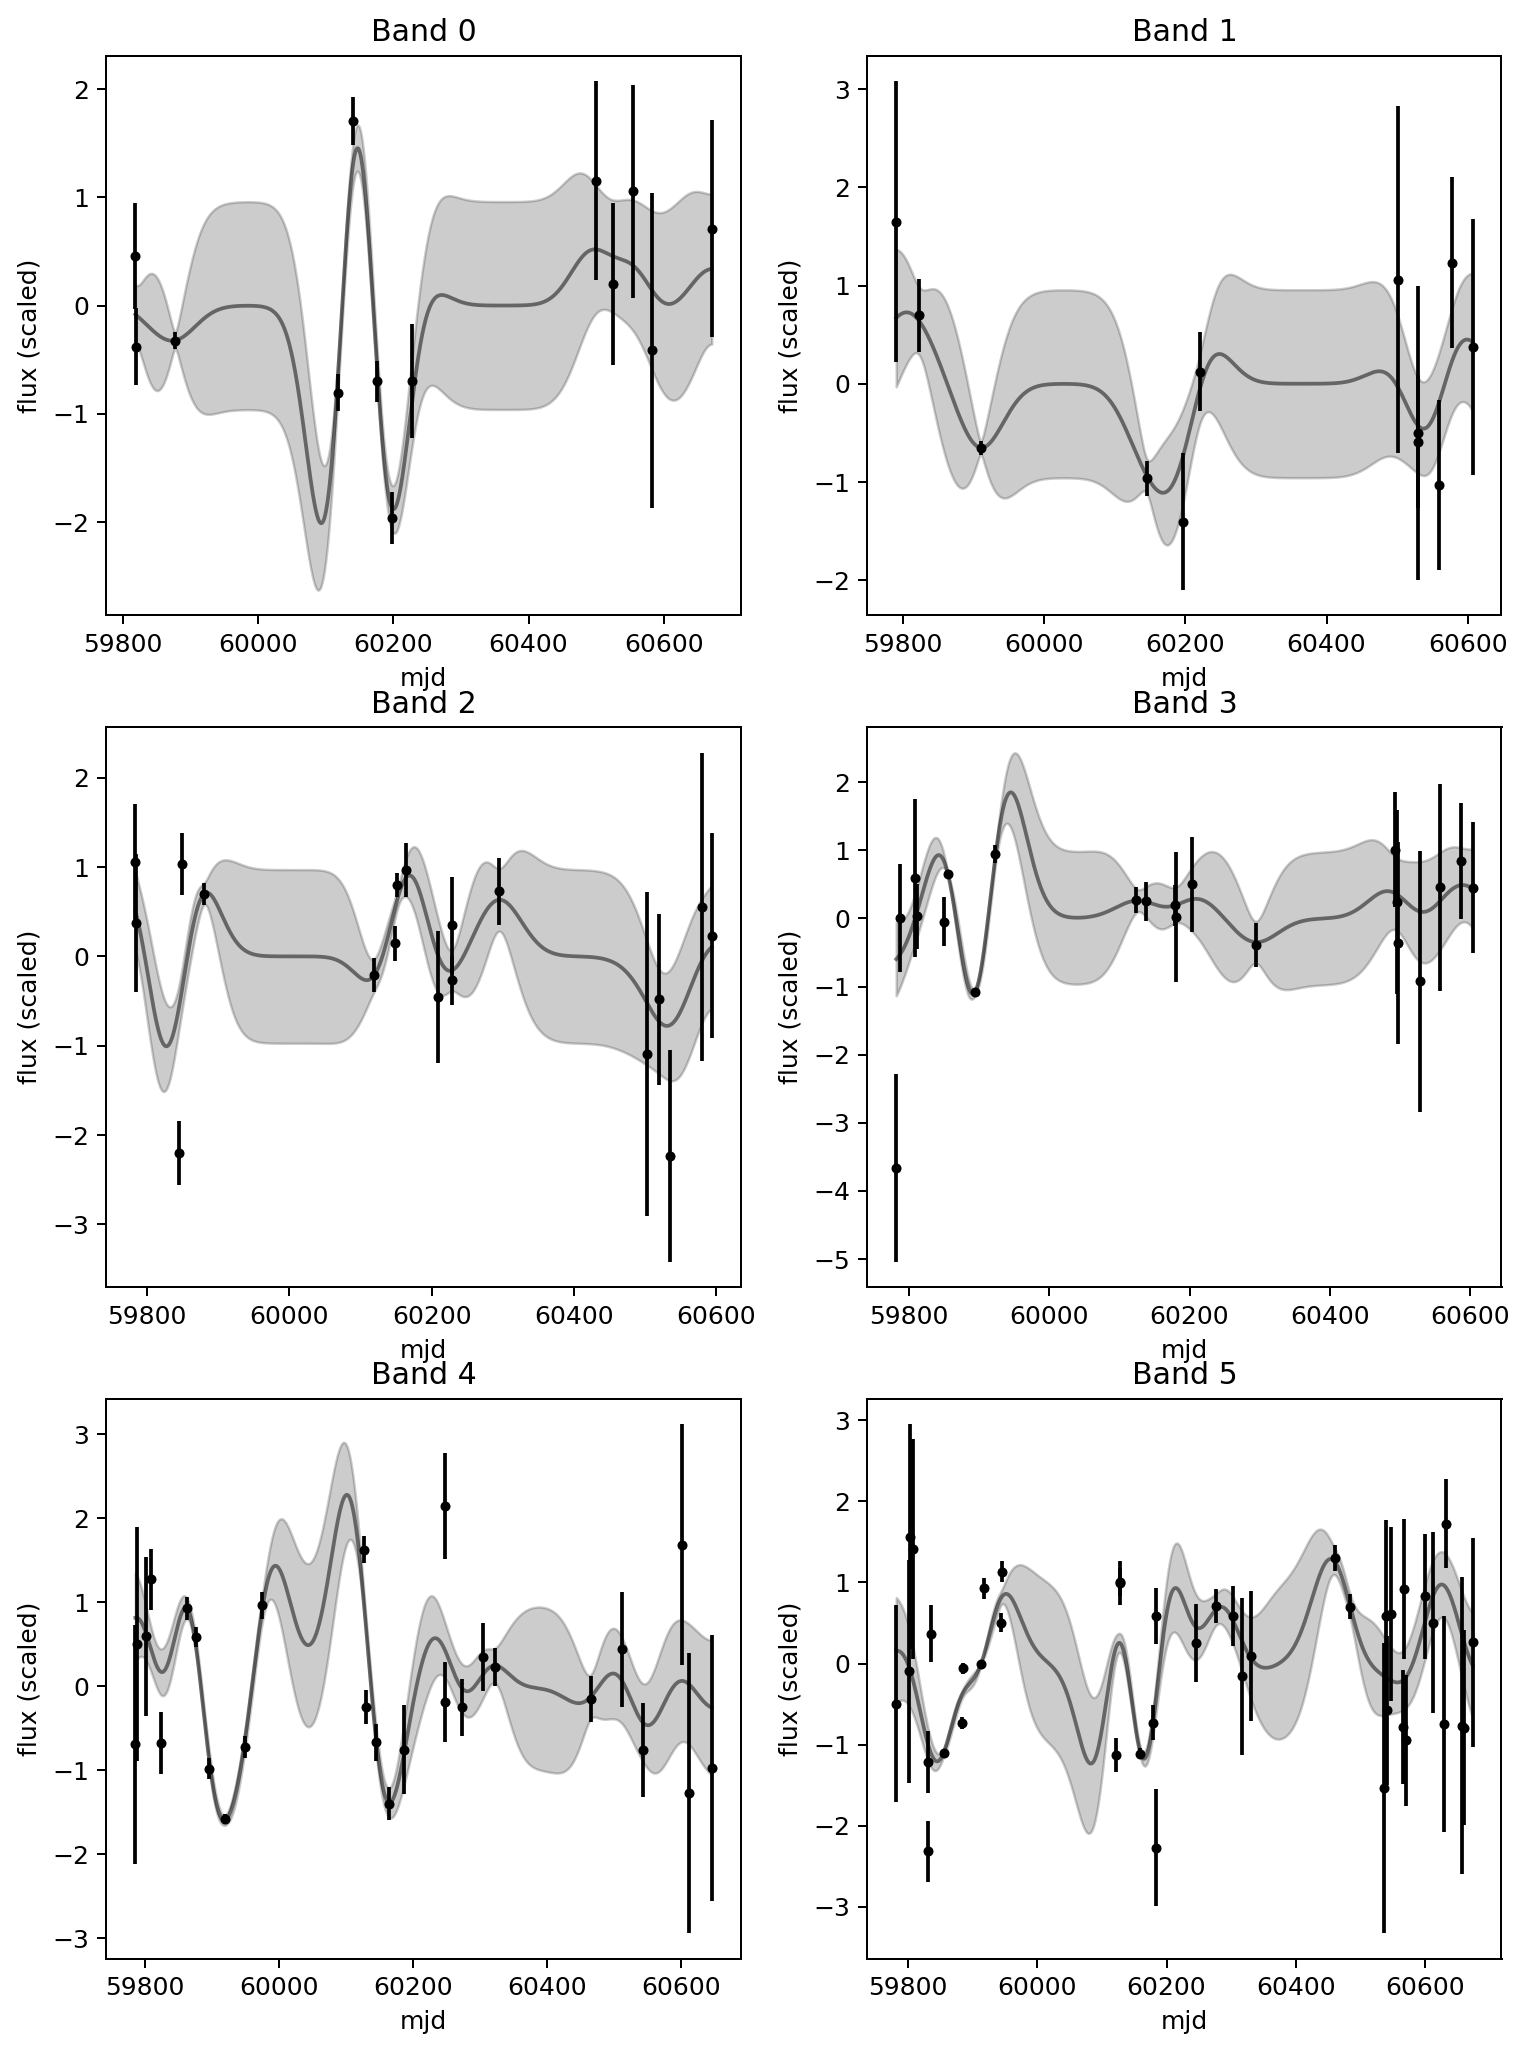

In [ ]:
# np.random.seed = 1
# id = np.random.choice(lcvs["object_id"].unique(), 1)[0]
id = 92053866
pl.figure(figsize=(10,14), dpi=180)

for i in range(6):
  pl.subplot(3, 2, i+1)
  y = lcvs[lcvs["object_id"] == id][lcvs[lcvs["object_id"] == id]["passband"] == i]["flux_scaled"].values
  t = lcvs[lcvs["object_id"] == id][lcvs[lcvs["object_id"] == id]["passband"] == i]["mjd"].values
  yerr = lcvs[lcvs["object_id"] == id][lcvs[lcvs["object_id"] == id]["passband"] == i]["flux_err_scaled"].values
  t_pred = np.linspace(min(t), max(t), 30000)

  kernel = np.var(y) * kernels.ExpSquaredKernel(1000)
  gp = george.GP(kernel)
  gp.compute(t, yerr)

  pred, pred_var = gp.predict(y, t_pred, return_var=True)
  pl.fill_between(t_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                  color="k", alpha=0.2)
  pl.plot(t_pred, pred, "k", lw=1.5, alpha=0.5)
  pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
  pl.title(f"Band {i}")
  pl.xlabel("mjd")
  pl.ylabel("flux (scaled)");

  # print(id)
  print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
  print("Initial parameters: {0:.2f}".format(*gp.get_parameter_vector()))

Figure 4: Plots of the GP kernel ExpSquaredKernel for object 92053866. The GP provides pretty accurate lines, with most points/errorbars running through the lines. The gray area provides the 95% confidence interval and contains almost all of the points.

<font color="red">FBB these look good!</font>

In [ ]:
# these were found using np.random.choice(metadata["target"].unique(), 10, replace=False) to get unique class values. One value was then chosen from each class to get objects from different classes
unique_class_obj = [114467134,11332773,123621973,55427870,65102455,51494983,57681583,47356721,320018,50154052]
GP_dict = {}
likelihoods = []
parameters = []

for obj in unique_class_obj:
  GP_dict[obj] = []
  for i in range(6):
    y = lcvs[lcvs["object_id"] == obj][lcvs[lcvs["object_id"] == obj]["passband"] == i]["flux_scaled"].values
    t = lcvs[lcvs["object_id"] == obj][lcvs[lcvs["object_id"] == obj]["passband"] == i]["mjd"].values
    yerr = lcvs[lcvs["object_id"] == obj][lcvs[lcvs["object_id"] == obj]["passband"] == i]["flux_err_scaled"].values
    t_pred = np.linspace(min(t), max(t), 10000)

    kernel = np.var(y) * kernels.ExpSquaredKernel(1000)
    gp = george.GP(kernel)
    gp.compute(t, yerr)

    pred, pred_var = gp.predict(y, t_pred, return_var=True)
    GP_dict[obj].append((gp.log_likelihood(y), gp.get_parameter_vector()[0]))
    # print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
    # print("Initial parameters: {0:.2f}".format(*gp.get_parameter_vector()))

In [ ]:
for key in GP_dict:
  print(f"object {key}: {GP_dict[key]}\n")

object 114467134: [(-57.61488397505102, -0.0689928714869512), (-14.706399092532628, -0.09531017980432464), (-223.18189904712065, -0.03922071315328173), (-30.486117510094708, -0.03636764417087506), (-116.63697060713153, -0.031748698314580416), (-123.23324552983014, -0.028987536873252073)]

object 11332773: [(-42.08045899364608, -0.07410797215372172), (-61.533108857671735, -0.08004270767353625), (-20.53662681480651, -0.042559614418796236), (-18.976776557446605, -0.044451762570833345), (-32.94358975861239, -0.030771658666754003), (-297.3258798509325, -0.028170876966696335)]

object 123621973: [(-75.40093700718174, -0.0689928714869512), (-38.997042177467094, -0.07410797215372185), (-31.746424272660434, -0.060624621816434854), (-18.466734477437793, -0.06062462181643509), (-50.64570907177204, -0.039220713153281385), (-161.05777378680546, -0.03509131981126994)]

object 55427870: [(-16.800221733655576, -0.08701137698962992), (-16.96132095967712, -0.07410797215372196), (-19.956586105992912, -0.

The variance for parameters is tiny, they can probably use the same kernel.

In [ ]:
from scipy.optimize import minimize

y = lcvs[lcvs["object_id"] == 114467134][lcvs[lcvs["object_id"] == 114467134]["passband"] == 1]["flux_scaled"].values
t = lcvs[lcvs["object_id"] == 114467134][lcvs[lcvs["object_id"] == 114467134]["passband"] == 1]["mjd"].values
yerr = lcvs[lcvs["object_id"] == 114467134][lcvs[lcvs["object_id"] == 114467134]["passband"] == 1]["flux_err_scaled"].values

kernel = kernels.ExpSquaredKernel(1000)
gp = george.GP(kernel)
gp.compute(t, 0)

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)
gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
print("Optimized parameters: {0:.2f}".format(*gp.get_parameter_vector()))

      fun: 14.739195735936
 hess_inv: array([[2.41280888]])
      jac: array([1.1528361e-06])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 11
     njev: 12
   status: 0
  success: True
        x: array([2.82856566])

Final ln-likelihood: -14.74
Optimized parameters: 2.83


<font color="red">FBB ok, would have been good to replot with new parameters</font>

# CHALLENGE (Extra Credit): fit the 2D time series: 
- create a 2D array for each of the ~10 time series you used earlier: 1 dimension is time the other is wavelength (the bandpass)
- fit a 2D kernel to the time series. 
- show the fits with their uncertainties marginalized along one feature at a time: the fit along the time axis for all 6 bands and the fit along the wavelength axis for a subset of the datapoints.
- (try and make a surface plot  that conveys the relevant info effectively, I find it difficult)